In [9]:
from policy_net.environment import Environment
from policy_net.learning_agent import LearningAgent
from policy_net.animate import animate_species_ownership_with_static_layers, plot_agent_metrics, print_variable_significance, plot_dual_axis
from policy_net.game import play_game, finish_episode, log_channel_sums, save_checkpoint, load_checkpoint
from policy_net.policy_net import PolicyNet
from nca.constsants import CHANNELS, H, W, NUM_CHANNELS
from nca.nca_model import NCA, get_species_features_tensor,build_channel_mapping_from_species_list
from nca.generate_map import generate_training_world
import torch
import random
from nca.constsants import PLANT_RULES
from collections import Counter, defaultdict


In [2]:
torch.cuda.is_available()

True

In [10]:
# Setup

device = 'cuda' if torch.cuda.is_available() else 'cpu' #cuda

new_run = False
policy0 = PolicyNet(num_species=5, h=H, w=W).to(device)
policy1 = PolicyNet(num_species=5, h=H, w=W).to(device)
optimizer0 =  torch.optim.Adam(policy0.parameters(), lr=5e-4)
optimizer1 =  torch.optim.Adam(policy1.parameters(), lr=5e-4)

if not new_run:
    load_checkpoint(policy0, optimizer0, "supervised_pn.pth")
    load_checkpoint(policy1, optimizer1, "supervised_pn.pth")


agent0 = LearningAgent(agent_id=0, policy_net=policy0,  start_quadrant="top_left")
agent0.player_number = 1
agent1 = LearningAgent(agent_id=1, policy_net=policy1,  start_quadrant="bottom_right")
agent1.player_number = 2
agents = [agent0, agent1]


optimizers = [optimizer0, optimizer1]


plant_list = agents[0].available_species + agents[1].available_species
# CHANNELS["plants"] = {
#     plant_name: 6 + i
#     for i, plant_name in enumerate(plant_list)
# }
CHANNELS["plants"] = [
    (plant_name, 6 + i)
    for i, plant_name in enumerate(plant_list)
]
sample_species_features = get_species_features_tensor()

model = NCA(NUM_CHANNELS, sample_species_features.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load("./models/nca2.pth",map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()
species_combos = [
    ['grass_0', 'shrub_0', 'tree_0', 'shrub_1', 'tree_1'], 
    ['grass_1', 'shrub_2', 'tree_4', 'grass_0', 'tree_2'],
    ['grass_0', 'shrub_1', 'tree_2', 'grass_1', 'shrub_2'],
    ['grass_1', 'shrub_0', 'tree_0', 'tree_4', 'shrub_2'],
    ['grass_0', 'shrub_2', 'tree_1', 'shrub_1', 'grass_1'],
    ['grass_1', 'shrub_1', 'tree_2', 'tree_0', 'grass_0'],
    ['grass_3', 'shrub_3', 'tree_1', 'shrub_1', 'tree_0'],
    ['grass_0', 'shrub_4', 'tree_2', 'shrub_0', 'tree_3'],
    ['grass_1', 'shrub_2', 'tree_5', 'grass_3', 'shrub_4'],
    ['grass_2', 'shrub_1', 'tree_3', 'grass_0', 'shrub_3'],
    ['grass_3', 'shrub_0', 'tree_4', 'grass_1', 'tree_5']
]
def sample_curriculum_species_set():
    return random.choice(species_combos)
agent0.available_species = sample_curriculum_species_set()
agent1.available_species = sample_curriculum_species_set()
species_list = agents[0].available_species + agents[1].available_species

species_features = get_species_features_tensor(species_list=species_list)
build_channel_mapping_from_species_list(species_list) 

print(species_features.shape)
print(CHANNELS)
    
#agent1.randomize_species(5)


Checkpoint loaded from supervised_pn.pth, resuming at epoch 29000
Checkpoint loaded from supervised_pn.pth, resuming at epoch 29000
torch.Size([10, 17])
{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('grass_1', 6), ('shrub_1', 7), ('tree_2', 8), ('tree_0', 9), ('grass_0', 10), ('grass_1', 11), ('shrub_1', 12), ('tree_2', 13), ('tree_0', 14), ('grass_0', 15)]}


17

In [39]:

agent_logs = {
    agent.agent_id: defaultdict(list) for agent in agents
}
for agent_id in range(2):
    agent_logs[agent_id]["choices"] = []
base_episode = 0

In [40]:

import math
from collections import Counter, defaultdict
import numpy as np
from itertools import combinations

def compute_entropy(actions):
    if not actions:
        return 0.0
    counter = Counter(actions)
    total = sum(counter.values())
    return -sum((count / total) * math.log2(count / total) for count in counter.values())

#torch.autograd.set_detect_anomaly(True)
intervals = [1]
base_species = []

num_episodes = 2000
for episode in range(num_episodes):
    print(episode)
    grid, variety_idx = generate_training_world(H, W, seed_plants=False)
    grid = grid.to(device)
    ownership_grid = torch.full((1, H, W), fill_value=-1, dtype=torch.long, device=device)
    elevation_static = grid[:, CHANNELS["elevation"]].clone().detach()
    shade_static = grid[:, CHANNELS["shade"]].clone().detach()
    soil_static = {
        idx: grid[:, idx].clone().detach()
        for idx in CHANNELS["soil"].values()
    }
    for agent in agents:
        interval = intervals[int(len(intervals) * (episode / num_episodes))] 

        agent.randomize_species(5)
        #agent.available_species = sample_curriculum_species_set()
        # if episode % interval == 0:
        #     agent.available_species = sample_curriculum_species_set()
        #     agent.base_species = agent.available_species
        # elif episode % 10 == 0:
        #     agent.available_species =  sample_curriculum_species_set()
        # else:
        #     agent.available_species =  agent.base_species

        
        agent.species_used = []
        agent.row_used = []
        agent.column_used = []
        
    if random.random() < .5:
        agents[0].start_quadrant = "top_left"
        agents[0].player_number = 1
        agents[1].start_quadrant = "bottom_right"
        agents[1].player_number = 2
        species_list = agents[0].available_species + agents[1].available_species
    else:
        agents[1].start_quadrant = "top_left"
        agents[1].player_number = 1
        agents[0].start_quadrant = "bottom_right"
        agents[0].player_number = 2
        species_list = agents[1].available_species + agents[0].available_species

    species_features = get_species_features_tensor(species_list=species_list)
    build_channel_mapping_from_species_list(species_list) 

    # print(species_features)
    # print(CHANNELS)
    
    env = Environment(grid, model, ownership_grid, agents, elevation_static, soil_static, shade_static, species_features, species_list, steps_per_turn=5)
    
    game_rounds = 1
    if (agents[0].training_stage > 2):
        game_rounds = 2 * agents[0].training_stage
    env.steps_per_turn = int(20 / game_rounds)



    scores, actions = play_game(env, species_features, game_rounds ,False)

    #log_channel_sums(env.grid)
    def compute_agent_diversity_loss(actions, agent_id):

        # Filter to only actions taken by this agent
        filtered = [a for a in actions if a[0][0] == agent_id]
        if len(filtered) <= 1:
            return 0.0  # No diversity penalty for 0 or 1 action

        vecs = torch.tensor([a[0][1:] + a[1][1:] for a in filtered], device='cuda', dtype=torch.float32)
        dists = torch.cdist(vecs, vecs, p=2)
        similarities = torch.exp(-dists)
        mean_similarity = similarities.mean()

        return mean_similarity
    print(scores)
    print(CHANNELS)
    print(actions)
    for agent in agents: 

        diversity = compute_agent_diversity_loss(actions, agent.agent_id)
        diversity_bonus = len(agent.species_used) * 400
        #agent.diversity_reward = diversity_bonus
        
        reward = scores[agent.agent_id] + 5
        #if (agent.training_stage >= 5):   
            #agent.apply_game_end_reward(reward)
            #agent.rewards[-1] += (reward) * 20
  
        agent.check_curriculum()
        agent_choices = []
        
        species_used = 'none'
        for act in actions:
            species_id = act[agent.agent_id][1]
            x = act[agent.agent_id][2]
            y = act[agent.agent_id][3]
            agent_choices.append((species_id, x, y))
            species_used = species_list[species_id]
            
        print(f"{agent.agent_id}  --  {species_used}")

        log = agent_logs[agent.agent_id]
        log["choices"].append(agent_choices)
        log["episode"].append(base_episode + episode)
        log["world_variety"].append(variety_idx)
        log["player_number"].append(agent.player_number)
        log["species_set"].append(species_used)
        log["growth_reward"].append(agent.growth_reward)
        log["quadrant_penalty"].append(agent.quadrant_penalty)
        log["species_penalty"].append(agent.species_penalty)
        try:
            log["suitability_reward"].append(agent.suitability_reward.cpu().item())
        except:
            log["suitability_reward"].append(agent.suitability_reward)
        log["diversity_reward"].append(agent.diversity_reward)
        log["score"].append(reward)
        log["training_stage"].append(agent.training_stage)

        agent.log_and_reset_loss()
        

    grid.detach()
    for i in range(len(agents)):
        finish_episode(agents[i], optimizers[i], grid)
        
base_episode += episode

0
(0, 7, 30, 17)
(1, 2, 54, 36)
{0: 1.0, 1: 21.0}
{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('tree_1', 6), ('bad', 7), ('tree_4', 8), ('grass_0', 9), ('tree_0', 10), ('tree_5', 11), ('shrub_2', 12), ('tree_1', 13), ('shrub_3', 14), ('grass_3', 15)]}
[[(0, 7, 30, 17), (1, 2, 54, 36)]]
0  --  tree_1
1  --  tree_4
Agent 0 Reward ++++ [-10]
Agent 0 Loss ==== 0.0
Agent 1 Reward ++++ [12.684051513671875]
Agent 1 Loss ==== 0.0
1
(0, 4, 6, 13)
(1, 7, 38, 36)
{0: 47.0, 1: 20.0}
{'soil': {'loam': 0, 'clay': 1, 'sand': 2, 'peat': 3}, 'elevation': 4, 'shade': 5, 'plants': [('tree_2', 6), ('tree_0', 7), ('shrub_4', 8), ('bad', 9), ('grass_1', 10), ('bad', 11), ('tree_5', 12), ('tree_3', 13), ('grass_2', 14), ('shrub_4', 15)]}
[[(0, 4, 6, 13), (1, 7, 38, 36)]]
0  --  grass_1
1  --  tree_3
Agent 0 Reward ++++ [24.61292266845703]
Agent 0 Loss ==== 0.0
Agent 1 Reward ++++ [11.595420837402344]
Agent 1 Loss ==== 0.0
2
(0, 8, 10, 5)
(1, 2, 18, 4)
{0: 34.

In [41]:

plot_dual_axis(agent_logs)

Output()

In [15]:
plot_dual_axis(agent_logs)

Output()

In [24]:
def print_variable_significance(agent_logs):
    import pandas as pd
    import statsmodels.api as sm

    # Combine logs
    df0 = pd.DataFrame({
        "agent": 0,
        "score": agent_logs[0]["score"],
        "world_variety": agent_logs[0]["world_variety"],
        "species_set": agent_logs[0]["species_set"],
        "player_number": agent_logs[0]["player_number"]
    })

    df1 = pd.DataFrame({
        "agent": 1,
        "score": agent_logs[1]["score"],
        "world_variety": agent_logs[1]["world_variety"],
        "species_set": agent_logs[1]["species_set"],
        "player_number": agent_logs[1]["player_number"]
    })

    df = pd.concat([df0, df1], ignore_index=True)
    aggregated = df.groupby(["agent", "species_set"]).agg(
        total_score=("score", "sum"),
        num_rows=("score", "count")
    ).reset_index()
    print(aggregated)
    # One-hot encode categorical variables WITHOUT dropping first
    df_encoded = pd.get_dummies(df, columns=["world_variety", "species_set", "agent", "player_number"], drop_first=True)

    df_encoded = df_encoded.apply(pd.to_numeric, errors="coerce").dropna()

    X = df_encoded.drop(columns=["score"])
    X = sm.add_constant(X).astype(float)
    y = df_encoded["score"].astype(float)

    reg_model = sm.OLS(y, X).fit()
    print(reg_model.summary())

    print("\nCorrelation with score:")
    print(df[["score", "world_variety", "species_set", "player_number"]].corr(numeric_only=True)["score"])


print_variable_significance(agent_logs)

    agent species_set  total_score  num_rows
0       0         bad         70.0        14
1       0     grass_0     594560.0      2803
2       0     grass_1     266480.0      1720
3       0     grass_2        675.0        91
4       0     grass_3        660.0       125
5       0     shrub_0      12510.0       453
6       0     shrub_1         50.0        13
7       0     shrub_2       3415.0       188
8       0     shrub_3       5875.0       289
9       0     shrub_4       6090.0       387
10      0     shrub_5     403445.0      3848
11      0      tree_0        990.0       212
12      0      tree_1      51170.0      1746
13      0      tree_2         30.0         8
14      0      tree_3     213190.0      2674
15      0      tree_4     548790.0      5186
16      0      tree_5       1125.0       243
17      1         bad        115.0        26
18      1     grass_0     557905.0      2480
19      1     grass_1     436905.0      3010
20      1     grass_2        765.0        82
21      1 

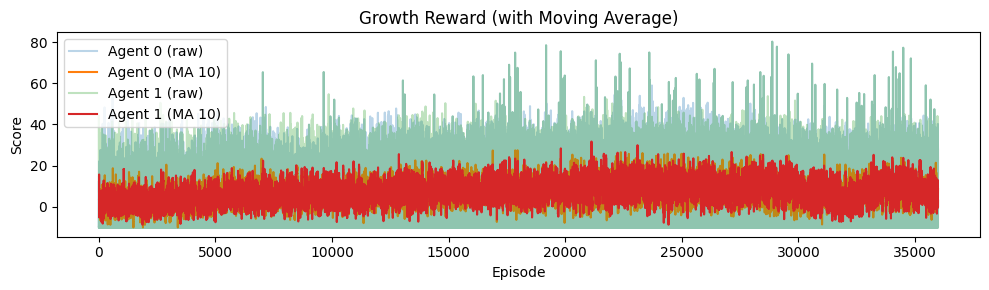

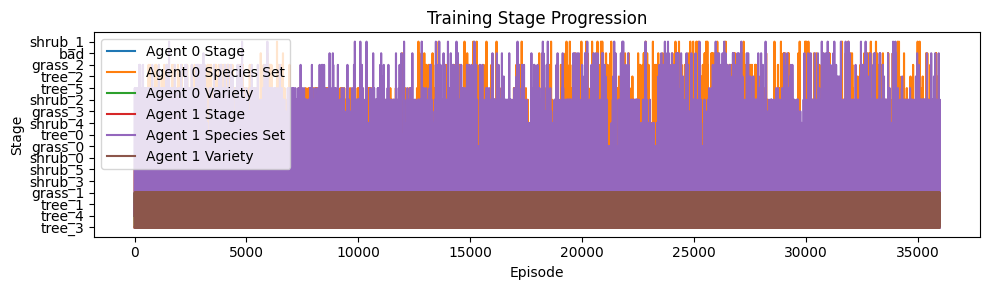

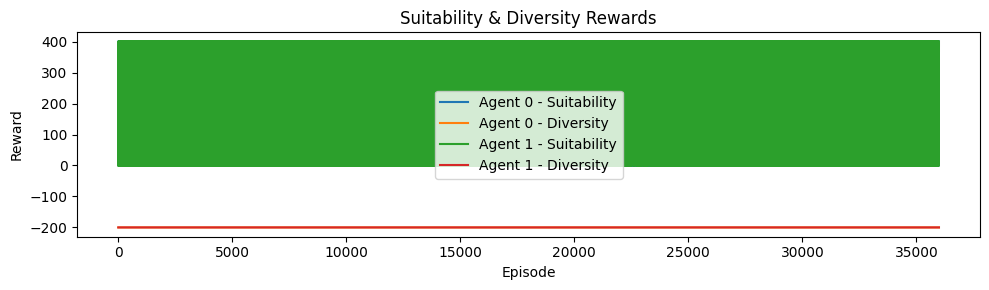

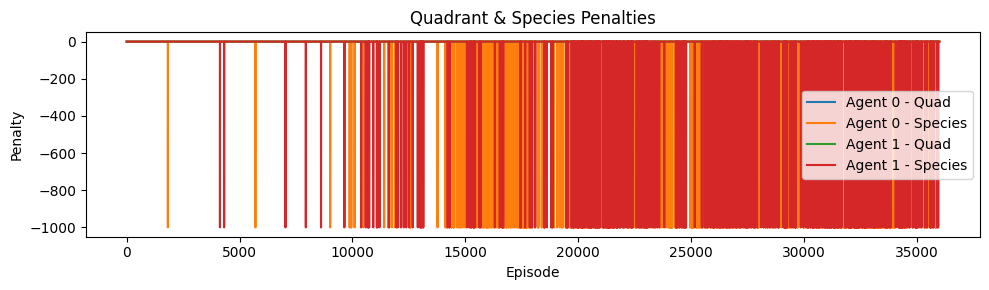

In [38]:
plot_agent_metrics(agent_logs)

In [44]:
save_checkpoint(policy0, optimizer0, 29000, "policy_net_may31.pth")
save_checkpoint(policy1, optimizer1, 29000, "policy_net_may31.pth")


Checkpoint saved at policy_net_may31.pth
Checkpoint saved at policy_net_may31.pth


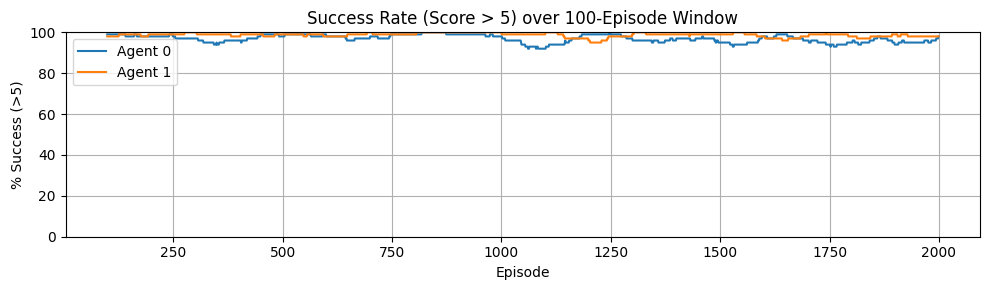

In [43]:
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported if it's not already

def plot_success_rate(agent_logs, threshold=5, window=100):
    episodes = list(next(iter(agent_logs.values()))["episode"])  # Assumes same episodes

    plt.figure(figsize=(10, 3))
    plt.title(f"Success Rate (Score > {threshold}) over {window}-Episode Window")

    for agent_id, log in agent_logs.items():
        scores = np.array(log["score"])
        successes = (scores > threshold).astype(int)
        rolling_success = np.convolve(successes, np.ones(window, dtype=int), mode='valid') / window * 100
        plt.plot(episodes[window - 1:], rolling_success, label=f"Agent {agent_id}")

    plt.xlabel("Episode")
    plt.ylabel(f"% Success (>{threshold})")
    plt.ylim(0, 100)
    plt.grid(True)  # Add gridlines
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_success_rate(agent_logs)

In [10]:
# Step 1: Find the minimum length across all log fields for all agents
min_len = float('inf')
for agent_logs_dict in agent_logs.values():
    for log_list in agent_logs_dict.values():
        min_len = min(min_len, len(log_list))

# Step 2: Trim all logs to that minimum length
for agent_id, logs in agent_logs.items():
    for key in logs:
        logs[key] = logs[key][:min_len]


In [6]:

def print_species_choice_counts(agent_logs, possible_species_combos):
    for agent_id in range(2):
        log = agent_logs[agent_id]
        species_counts = Counter()

        for episode_idx, episode_choices in enumerate(log["choices"]):
            species_set_idx = log["species_set"][episode_idx]
            species_set = possible_species_combos[species_set_idx]
            player_number = log["player_number"][episode_idx]

            for sid, _, _ in episode_choices:
                local_sid = sid if player_number == 1 else sid - 5
                if 0 <= local_sid < len(species_set):
                    species_name = species_set[local_sid]
                    species_counts[species_name] += 1
                else:
                    print(f"[Warning] Invalid sid={sid} for agent {agent_id}, episode {episode_idx}")

        print(f"\nAgent {agent_id} species choice counts:")
        for species, count in species_counts.most_common():
            print(f"  {species:15s}: {count}")
print_species_choice_counts(agent_logs, possible_species_combos)

NameError: name 'possible_species_combos' is not defined

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter

def plot_species_choices_over_time(agent_logs, possible_species_combos, window=20):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter

    for agent_id, log in agent_logs.items():
        choices = log["choices"]  # List of list of (species_id, x, y)
        episodes = log["episode"]
        species_sets = log["species_set"]
        player_numbers = log["player_number"]  # <- NEW

        all_species_names = sorted({s for combo in possible_species_combos for s in combo})
        species_name_to_index = {name: i for i, name in enumerate(all_species_names)}
        num_species = len(all_species_names)

        freq_matrix = []

        for i in range(len(choices) - window + 1):
            flat_species_names = []
            for j in range(i, i + window):
                species_set = possible_species_combos[species_sets[j]]
                player_number = player_numbers[j]

                for sid, _, _ in choices[j]:
                    # Normalize sid to local index
                    local_sid = sid if player_number == 1 else sid - 5
                    if 0 <= local_sid < len(species_set):
                        species_name = species_set[local_sid]
                        flat_species_names.append(species_name)
                    else:
                        print(f"[Warning] sid {sid} out of range at episode {episodes[j]}")
            
            counts = Counter(flat_species_names)
            total = sum(counts.values())
            freqs = [counts.get(name, 0) / total if total > 0 else 0.0 for name in all_species_names]
            freq_matrix.append(freqs)

        freq_matrix = np.array(freq_matrix)
        moving_episodes = episodes[window - 1:]

        # Plot
        plt.figure(figsize=(12, 4))
        plt.title(f"Agent {agent_id} - Species Choice Frequency (Window={window})")
        for i, name in enumerate(all_species_names):
            plt.plot(moving_episodes, freq_matrix[:, i], label=name)
        plt.xlabel("Episode")
        plt.ylabel("Species Usage %")
        plt.ylim(0, 1)
        plt.legend(loc="upper right", ncol=3, fontsize=8)
        plt.tight_layout()
        plt.show()



plot_species_choices_over_time(agent_logs, possible_species_combos)

NameError: name 'possible_species_combos' is not defined

In [ ]:
grid, variety_idx = generate_training_world(H, W, seed_plants=False).to(device)
ownership_grid = torch.full((1, H, W), fill_value=-1, dtype=torch.long, device=device)
elevation_static = grid[:, CHANNELS["elevation"]].clone().detach()
shade_static = grid[:, CHANNELS["shade"]].clone().detach()

soil_static = {
    idx: grid[:, idx].clone().detach()
    for idx in CHANNELS["soil"].values()
}

agent0Species = ["grass_0", "shrub_0", "tree_0", "grass_1","shrub_2"]
agent1Species = ["grass_1", "shrub_1", "tree_1", "grass_2","tree_2"]

agent0 = LearningAgent(agent_id=0, policy_net=policy0, available_species=agent0Species, start_quadrant="top_left", agent_mask=agent_0_mask)
agent1 = LearningAgent(agent_id=1, policy_net=policy1, available_species=agent1Species, start_quadrant="bottom_right", agent_mask=agent_1_mask)
agents = [agent0, agent1]

agents[0].player_number = 1
agents[1].player_number = 2


species_list = agents[0].available_species + agents[1].available_species
species_features = get_species_features_tensor(species_list=species_list)   
build_channel_mapping_from_species_list(species_list)   
print(species_features.shape)

env = Environment(grid, model, ownership_grid, agents, elevation_static, soil_static, shade_static, species_features, species_list, steps_per_turn=5)


scores = play_game(env, species_features, max_turns=15)
print(scores)
ani = animate_species_ownership_with_static_layers(env, elevation_static, soil_static)
from IPython.display import HTML
HTML(ani.to_jshtml())


NameError: name 'generate_training_world' is not defined

In [ ]:
log["suitability_reward"].append(0)
log["diversity_reward"].append(0)
log["score"].append(0)
log["training_stage"].append(4)

In [ ]:
import torch

# Set model to evaluation mode
model = PolicyNet(5, H, W)
checkpoint = torch.load("policy_net.pth", map_location="cpu")  # Force loading on CPU
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # ← disables dropout, noise, etc.


PolicyNet(
  (conv1): Conv2d(17, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (location_head): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (avgpool): AvgPool2d(kernel_size=(16, 16), stride=(16, 16), padding=0)
  (env_proj): Linear(in_features=32, out_features=64, bias=True)
  (species_proj): Linear(in_features=17, out_features=64, bias=True)
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
import torch

# Load model
model = PolicyNet(num_species=5, h=64, w=64)  # Update num_species as needed
checkpoint = torch.load("policy_net_may31.pth", map_location="cpu")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create dummy inputs
dummy_grid = torch.zeros(1, NUM_CHANNELS + 1, H, W)  # input grid with mask
dummy_species_features = torch.zeros(10, 17)  # match species_feature_dim

# Export
torch.onnx.export(
    model,
    (dummy_grid, dummy_species_features),
    "policy_net.onnx",
    input_names=["grid", "species_features"],
    output_names=["species_logits", "location_logits"],
    opset_version=13,    
    export_params=True,
    verbose=False,
)



RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x17 and 18x64)

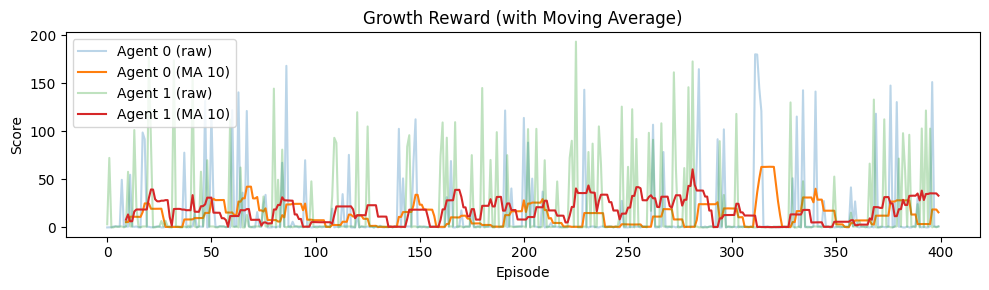

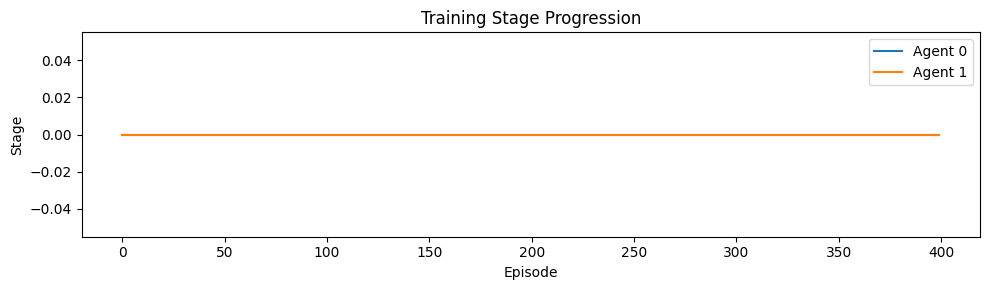

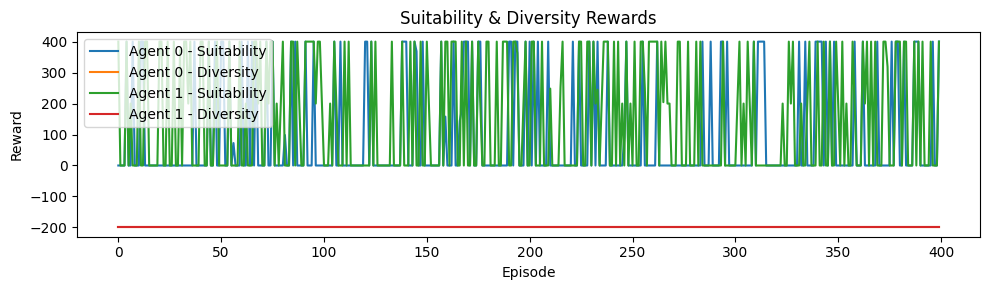

ValueError: x and y must have same first dimension, but have shapes (400,) and (0,)

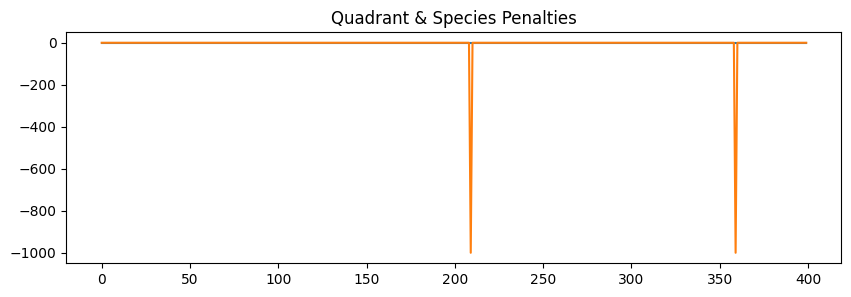